#Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd

#!pip install -r requirements.txt
!pip install tensorflow==2.2.0
!pip install ray[rllib]==0.8.5

!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: gast, wrapt, astunparse, scipy, termcolor, google-pasta, tensorflow-estimator, six, keras-preprocessing, protobuf, tensorboard, absl-py, opt-einsum, numpy, wheel, h5py, grpcio
Required-by: fancyimpute
Name: ray
Version: 0.8.5
Summary: A system for parallel and distributed Python that unifies the ML ecosystem.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /

#Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import create_storage, create_train_policy_list, get_last_eps_steps, get_lv_data, get_lv_dict
from gym_continuousDoubleAuction.train.callbk.callbk_handler import create_step_callbk_list, create_callbk_list, store_user_obs, store_user, store_step_hist, store_hist, access_sample_batches, all_steps_store_obs, all_steps_store, all_eps_store
from gym_continuousDoubleAuction.train.logger.log_handler import callbk_counter, file_num, log_threshold, create_dir, log_json, load_json, log_eps, load_eps, log_json_gzip, load_json_gzip
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_steps, plot_eps, show_obs, plot_last_eps_steps, plot_sum_imb, plot_imb, subplot_lv
from gym_continuousDoubleAuction.train.helper.helper import size_imb, midpt_price, sum_all_lv

tf = try_import_tf()

In [0]:
@ray.remote(num_cpus=0.25, num_gpus=0)
class storage():
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.prefix = "agt_"
        self.storage = self.create_storage(self.num_agents)
        print("storage self.storage", self.storage)

    def create_storage(self, num_agents):   
        """
        Global storage.
        """
        storage = {}
        for i in range(self.num_agents):
            storage[self.prefix + str(i)] = {"step": {"obs": [], 
                                                      "reward": [],
                                                      "NAV": [],
                                                      "num_trades": []},
                                             "eps":  {"policy_reward": [], 
                                                      "reward": [],
                                                      "NAV": [],
                                                      "num_trades": []}}
        return storage     

    def store(self, agt_id, step_or_eps, key, data):
        """
        agt_id: int
        step_or_eps: string
        key: string
        data: steps (in a list) or episodic data (a numeric value)
        """
        self.storage[self.prefix + str(agt_id)][step_or_eps][key].append(data)            

    def store_agt_step(self, agt_id, obs, reward, NAV, num_trades):
        self.store(agt_id, "step", "obs", obs)     # a dictionary
        self.store(agt_id, "step", "reward", reward)
        self.store(agt_id, "step", "NAV", NAV)
        self.store(agt_id, "step", "num_trades", num_trades)

    def store_agt_eps(self, agt_id, reward, NAV, num_trades):
        self.store(agt_id, "eps", "reward", reward)
        self.store(agt_id, "eps", "NAV", NAV)
        self.store(agt_id, "eps", "num_trades", num_trades)

    def store_agt_train(self, agt_id, policy_reward):
        self.store(agt_id, "eps", "policy_reward", policy_reward)     

    def store_step(self, episode):
        """
        Called in on_episode_step.
        Store step data into storage.
        """
        for agt_id in range(self.num_agents):
            obs = episode.last_raw_obs_for(agt_id)
            #obs = episode.last_observation_for(agt_id)          
            reward = episode.last_info_for(agt_id).get("reward")
            NAV = episode.last_info_for(agt_id).get("NAV")
            num_trades = episode.last_info_for(agt_id).get("num_trades")

            self.store_agt_step(agt_id, obs, reward, NAV, num_trades)   

            obs_key = self.prefix + str(agt_id) + "_obs_step"
            reward_key = self.prefix + str(agt_id) + "_reward_step"
            NAV_key = self.prefix + str(agt_id) + "_NAV_step"
            num_trades_key = self.prefix + str(agt_id) + "_num_trades_step"
            #episode.user_data[obs_key].append(obs)
            #episode.user_data[reward_key].append(reward)
            #episode.user_data[NAV_key].append(NAV)
            #episode.user_data[num_trades_key].append(num_trades)

    def store_eps(self, episode):
        """
        Called in on_episode_end.
        Store data (sum a list of steps from 1 episode) into storage.
        """
        for agt_id in range(self.num_agents):
            reward_key = self.prefix + str(agt_id) + "_reward_step"
            NAV_key = self.prefix + str(agt_id) + "_NAV_step"
            num_trades_key = self.prefix + str(agt_id) + "_num_trades_step"

            reward = np.sum(episode.user_data[reward_key])
            NAV = np.sum(episode.user_data[NAV_key])
            num_trades = np.sum(episode.user_data[num_trades_key])

            self.store_agt_eps(agt_id, reward, NAV, num_trades)   

    #def store_train(self, info):
    def store_train(self, hist_stats, eps_this_iter):
        """
        Called in on_train_result.
        Store train data per iteration into storage.        
        """
        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = info["result"]["hist_stats"]
        eps_this_iter = info["result"]["episodes_this_iter"]
        for agt_id in range(self.num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                self.store_agt_train(agt_id, hist_stats[key][i])   

    def get_storage(self):
        return self.storage            

#Global


In [0]:
# CDA_env args
num_agents = 5
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 10 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

# step storages
obs_step_store = create_storage(num_agents, "agt_", "_obs_step_list")
reward_step_store = create_storage(num_agents, "agt_", "_reward_step_list")
NAV_step_store = create_storage(num_agents, "agt_", "_NAV_step_list")
num_trades_step_store = create_storage(num_agents, "agt_", "_num_trades_step_list")

# episodic storages
policy_reward_store = create_storage(num_agents, "agt_", "_policy_reward_list")
reward_store = create_storage(num_agents, "agt_", "_reward_list")
NAV_store = create_storage(num_agents, "agt_", "_NAV_list")
num_trades_store = create_storage(num_agents, "agt_", "_num_trades_list")

# storage for json input
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
num_cpus_per_worker = 0.25                                
#num_gpus_per_worker = 0.125   
num_workers = 1
num_envs_per_worker = 1
sample_batch_size = 20
train_batch_size = 40
sgd_minibatch_size = 10
num_iters = 1

log_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/"

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 150
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

# log & load 
write_last_eps_steps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/"
write_eps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/"
create_dir(write_last_eps_steps_dir)    
create_dir(write_eps_dir)    
threshold = log_threshold(num_workers, num_envs_per_worker, num_iters, num_agents)
print("threshold", threshold)

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
g_store = storage.options(name="g_store", detached=True).remote(num_agents)
print("on the driver", ray.get(g_store.get_storage.remote()))  

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-06-13 17:03:51,592	INFO resource_spec.py:212 -- Starting Ray with 7.08 GiB memory available for workers and up to 3.55 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']
Folder creation failed or folder already exists: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/
Folder creation failed or folder already exists: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/
num_eps 1
threshold 0


2020-06-13 17:03:52,067	INFO services.py:1170 -- View the Ray dashboard at 127.0.0.1:8265


on the driver {'agt_0': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_1': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_2': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_3': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_4': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}}


#Policies

In [0]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            #print("policy_{}".format(i))
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_4': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


# Call back.

In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    #print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))

    create_step_callbk_list(num_agents, episode, "_obs_step")

    create_step_callbk_list(num_agents, episode, "_reward_step")
    create_step_callbk_list(num_agents, episode, "_NAV_step")
    create_step_callbk_list(num_agents, episode, "_num_trades_step")

    create_callbk_list(num_agents, episode, "_reward")
    create_callbk_list(num_agents, episode, "_NAV")
    create_callbk_list(num_agents, episode, "_num_trades")

(pid=6623) storage self.storage {'agt_0': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_1': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_2': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_3': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}, 'agt_4': {'step': {'obs': [], 'reward': [], 'NAV': [], 'num_trades': []}, 'eps': {'policy_reward': [], 'reward': [], 'NAV': [], 'num_trades': []}}}


In [0]:
def on_episode_step(info):
    episode = info["episode"]

    store_user_obs(num_agents, episode, "_obs_step", "obs")
    store_user(num_agents, episode, "_reward_step", "reward")
    store_user(num_agents, episode, "_NAV_step", "NAV")
    store_user(num_agents, episode, "_num_trades_step", "num_trades")     

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]

    #store_step_hist(episode, "_obs_step")

    store_step_hist(num_agents, episode, "_reward_step")
    store_step_hist(num_agents, episode, "_NAV_step")
    store_step_hist(num_agents, episode, "_num_trades_step")     

    store_hist(num_agents, episode, "reward")
    store_hist(num_agents, episode, "NAV")
    store_hist(num_agents, episode, "num_trades")

    g_store = ray.util.get_actor("g_store")
    #ray.get(g_store.store_eps.remote(episode))

    prefix = "agt_"
    for agt_id in range(num_agents):
        obs_key = prefix + str(agt_id) + "_obs_step"
        reward_key = prefix + str(agt_id) + "_reward_step"
        NAV_key = prefix + str(agt_id) + "_NAV_step"
        num_trades_key = prefix + str(agt_id) + "_num_trades_step"
        
        obs = episode.user_data[obs_key]
        reward = episode.user_data[reward_key]
        NAV = episode.user_data[NAV_key]
        num_trades = episode.user_data[num_trades_key]

        ray.get(g_store.store_agt_step.remote(agt_id, obs, reward, NAV, num_trades))       
    
    for agt_id in range(num_agents):
        reward_key = prefix + str(agt_id) + "_reward_step"
        NAV_key = prefix + str(agt_id) + "_NAV_step"
        num_trades_key = prefix + str(agt_id) + "_num_trades_step"

        reward = np.sum(episode.user_data[reward_key])
        NAV = np.sum(episode.user_data[NAV_key])
        num_trades = np.sum(episode.user_data[num_trades_key])

        #self.store_agt_eps(agt_id, reward, NAV, num_trades)    
        ray.get(g_store.store_agt_eps.remote(agt_id, reward, NAV, num_trades))
    
    print("on_episode_end", ray.get(g_store.get_storage.remote()))     


In [0]:
def on_sample_end(info):
    """
    arg: {"samples": .., "worker": ...}
    """

    """
    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """
    MultiAgentBatch_obj = info["samples"]
    MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
    MultiAgentBatch_count = MultiAgentBatch_obj.count

    #access_sample_batches(MultiAgentBatch_policy_batches)
    #print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
    #print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    #all_steps_store_obs(info, obs_step_store, "agt_", "_obs_step", "_obs_step_list = {}")     

    all_steps_store(info, reward_step_store, "agt_", "_reward_step", "_reward_step_list = {}")     
    all_steps_store(info, NAV_step_store, "agt_", "_NAV_step", "_NAV_step_list = {}")     
    all_steps_store(info, num_trades_step_store, "agt_", "_num_trades_step", "_num_trades_step_list = {}")     

    """
    BUG:

    Need to sum for reward, NAV, num_trades for all steps to get episodic data.

    policy_reward is episodes per iteration based, can have > 0 steps or episodes per iteration.
    Should sum this values per iteration as a decision criterion for naive self-play weight sync.
    More sophisticated weight sync strategies (such as inheritence in PBT) could use this value as a score for ratings computation.
    """
    all_eps_store(info, policy_reward_store, "policy_policy_", "_reward", "_policy_reward_list[0] = {}")    
    all_eps_store(info, reward_store, "agt_", "_reward", "_reward_list[0] = {}") 
    all_eps_store(info, NAV_store, "agt_", "_NAV", "_NAV_list[0] = {}") 
    all_eps_store(info, num_trades_store, "agt_", "_num_trades", "_num_trades_list[0] = {}") 

    #print("on_train_result info['result'] {}".format(info["result"]))     

    g_store = ray.util.get_actor("g_store")    
    
    prefix = "policy_policy_"
    suffix = "_reward"
    hist_stats = info["result"]["hist_stats"]
    eps_this_iter = info["result"]["episodes_this_iter"]
    for agt_id in range(num_agents):
        key = prefix + str(agt_id) + suffix
        for i in range(eps_this_iter):
            ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

    print("on_train_result", ray.get(g_store.get_storage.remote()))     


In [0]:
def on_postprocess_traj(info):
    """
    arg: {"agent_id": ..., "episode": ...,
          "pre_batch": (before processing),
          "post_batch": (after processing),
          "all_pre_batches": (other agent ids),
          }

    # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
    Dictionaries in a sample_obj, k:
        t
        eps_id
        agent_index
        obs
        actions
        rewards
        prev_actions
        prev_rewards
        dones
        infos
        new_obs
        action_prob
        action_logp
        vf_preds
        behaviour_logits
        unroll_id       
    """
    #policy_obj = info["pre_batch"][0]
    sample_obj = info["pre_batch"][1]    
    agt_id = info["agent_id"]
    eps_id = info["episode"].episode_id

    # log steps for last episode for each agent
    global callbk_counter
    if callbk_counter >= threshold:
        print("on_postprocess_traj log_json callbk_counter = {}".format(callbk_counter))
        #log_json(agt_id, eps_id, sample_obj, write_last_eps_steps_dir)
        log_json_gzip(agt_id, eps_id, sample_obj, write_last_eps_steps_dir)        
    #else:        
    #    print("on_postprocess_traj callbk_counter = {}".format(callbk_counter))

    callbk_counter = callbk_counter + 1

    return

#RLlib config

In [0]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    #config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    #config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["rollout_fragment_length"] = sample_batch_size # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": on_episode_step, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": on_sample_end,
                           "on_postprocess_traj": on_postprocess_traj,
                           "on_train_result": on_train_result,}
    config["output"] = log_dir

    return config


#Train


In [0]:
def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print("training loop = {} of {}".format(i + 1, num_iters))            
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)
    print(pretty_print(result)) # includes result["custom_metrics"]


# run everything
go_train(get_config())            

2020-06-13 17:03:55,468	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-06-13 17:03:55,529	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
2020-06-13 17:03:55,531	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-06-13 17:03:55,543	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(pid=6622) 2020-06-13 17:04:06,417	WARNING deprecation.py:30 -- DeprecationWarning: `callbacks dict interface` has been deprecated. Use `a class extending rllib.agents.callbacks.DefaultCallbacks` instead. This will raise an error in the future!
(pid=6622) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=6622)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2020-06-13 17:04:15,792	INFO trainable.py:180 -- _setup took 20.269 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-06-13 17:04:15,793	INFO trainable.py:217 -- Getting current IP.
2020-06-13 17:04:15,798	WARNING util.py:37 -- Install gputil for GPU system monitoring.


(pid=6622) on_postprocess_traj log_json callbk_counter = 0
(pid=6622) on_postprocess_traj log_json callbk_counter = 1
(pid=6622) on_postprocess_traj log_json callbk_counter = 2
(pid=6622) on_postprocess_traj log_json callbk_counter = 3
(pid=6622) on_postprocess_traj log_json callbk_counter = 4
(pid=6622) on_episode_end {'agt_0': {'step': {'obs': [[[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ -71., -185.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
(pid=6622)           0.]), array([ -3., -25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])], [array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]), array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0

'reward': [[0.0, 781.0, 0.0, 0.0, 994.0, 0.0, 0.0, 355.0, 0.0, 0.0], 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
[0.0, 0.0, 0.0, 0.0, 5.333333333333333, 0.0, -80.0, 6.8, -170.0, 5.666666666666667], 
[0.0, 0.0, 0.0, 0.0, 288.6666666666667, 0.0, 1333.2, 0.0, 0.0, 0.0]], 

'NAV': [[1000000.0, 1001562.0, 1001562.0, 1001562.0, 1003550.0, 1003550.0, 1003550.0, 1004260.0, 1004260.0, 1004260.0], [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0], [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000016.0, 1000016.0, 1000000.0, 1000034.0, 1000000.0, 1000034.0], [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000866.0, 1000866.0, 1007532.0, 1007532.0, 1007532.0, 1007532.0]], 'num_trades': [[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 5.0], [0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 4.0, 5.0, 5.0]]}, 

'eps': {
  'policy_reward': [2130.0, 0.0, -232.20000000000002, 1621.8666666666668], 'reward': [2130.0, 0.0, -232.20000000000002, 1621.8666666666668], 
'NAV': [10028116.0, 10000000.0, 10000100.0, 10031860.0], 
'num_trades': [10.0, 0.0, 23.0, 22.0]}}}


# All steps from all episodes.

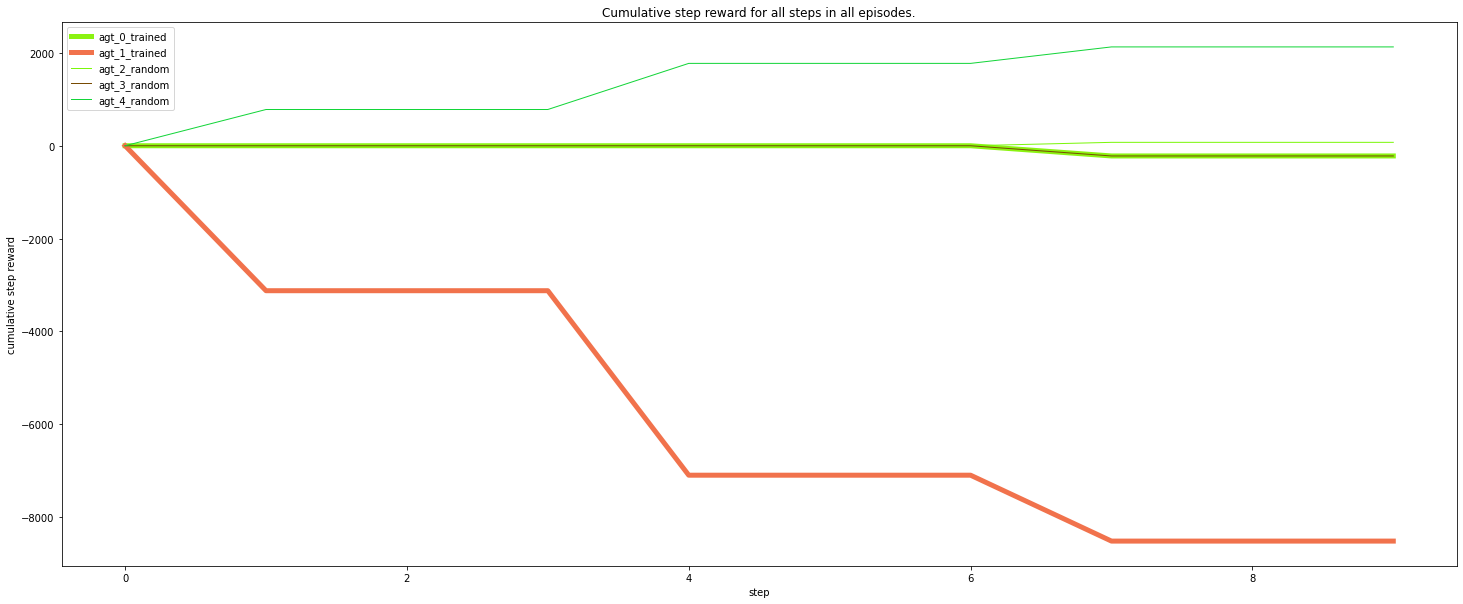

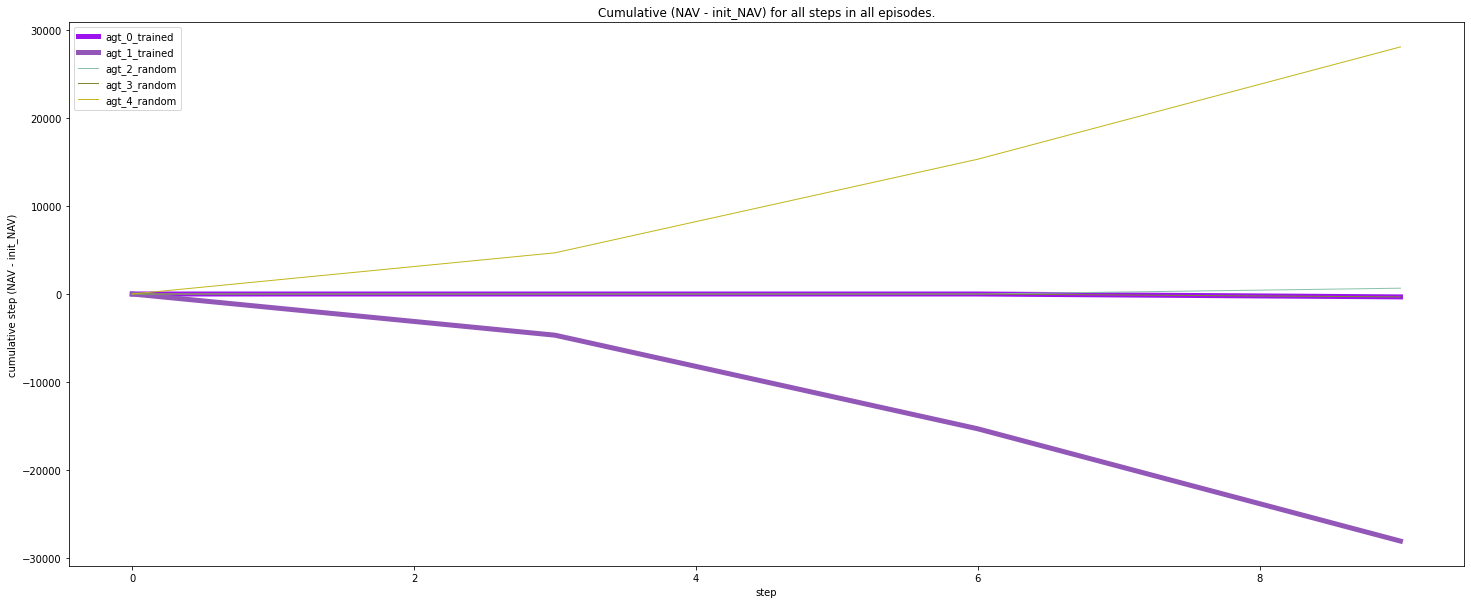

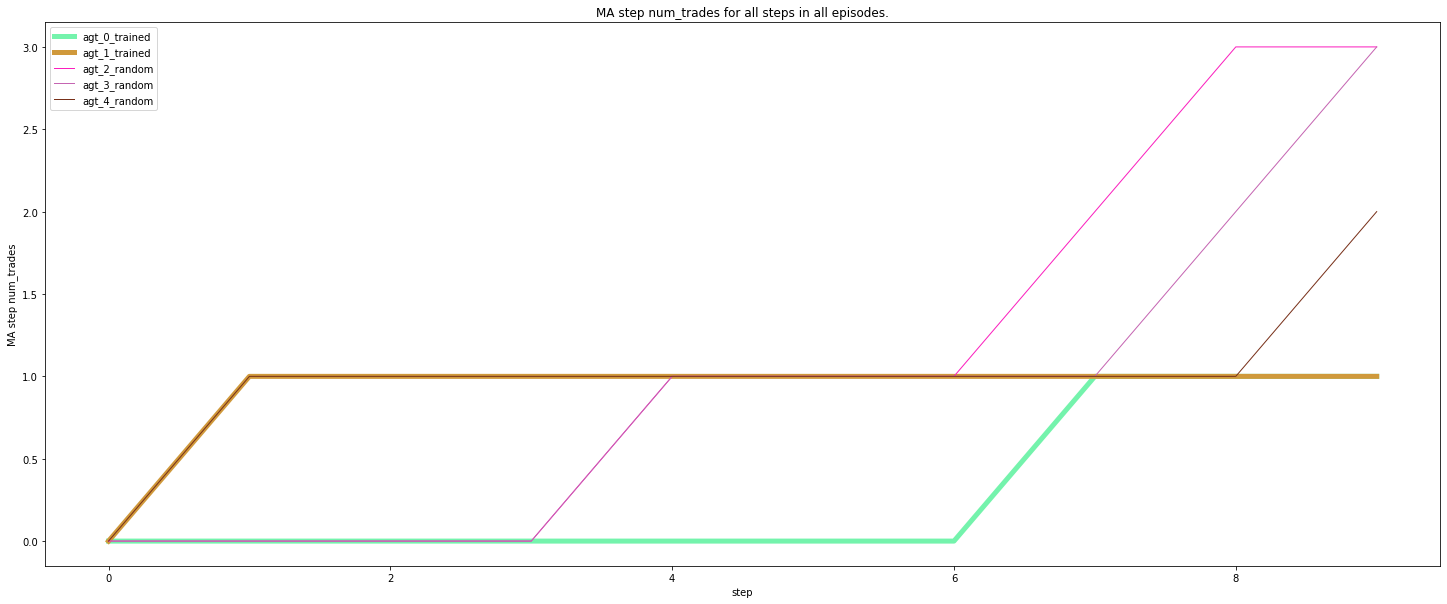

In [0]:
# Plot step results
plot_steps(init_cash, num_agents, num_trained_agent, "reward", reward_step_store, 'agt_', '_reward_step_list', '_trained', 'step', 'cumulative step reward', 'Cumulative step reward for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "NAV", NAV_step_store, 'agt_', '_NAV_step_list', '_trained', 'step', 'cumulative step (NAV - init_NAV)', 'Cumulative (NAV - init_NAV) for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_step_store, 'agt_', '_num_trades_step_list', '_trained', 'step', 'MA step num_trades', 'MA step num_trades for all steps in all episodes.') 

# Episodes

In [0]:
# Log episodes data to json files.
log_eps(write_eps_dir, "policy_reward", policy_reward_store)
log_eps(write_eps_dir, "reward", reward_store)
log_eps(write_eps_dir, "NAV", NAV_store)
log_eps(write_eps_dir, "num_trades", num_trades_store)

In [0]:
# Load episodes data from json files to dictionaries.
policy_reward_store = load_eps(write_eps_dir, 'policy_reward.dat', policy_reward_store)
reward_store = load_eps(write_eps_dir, 'reward.dat', reward_store)
NAV_store = load_eps(write_eps_dir, 'NAV.dat', NAV_store)
num_trades_store = load_eps(write_eps_dir, 'num_trades.dat', num_trades_store)

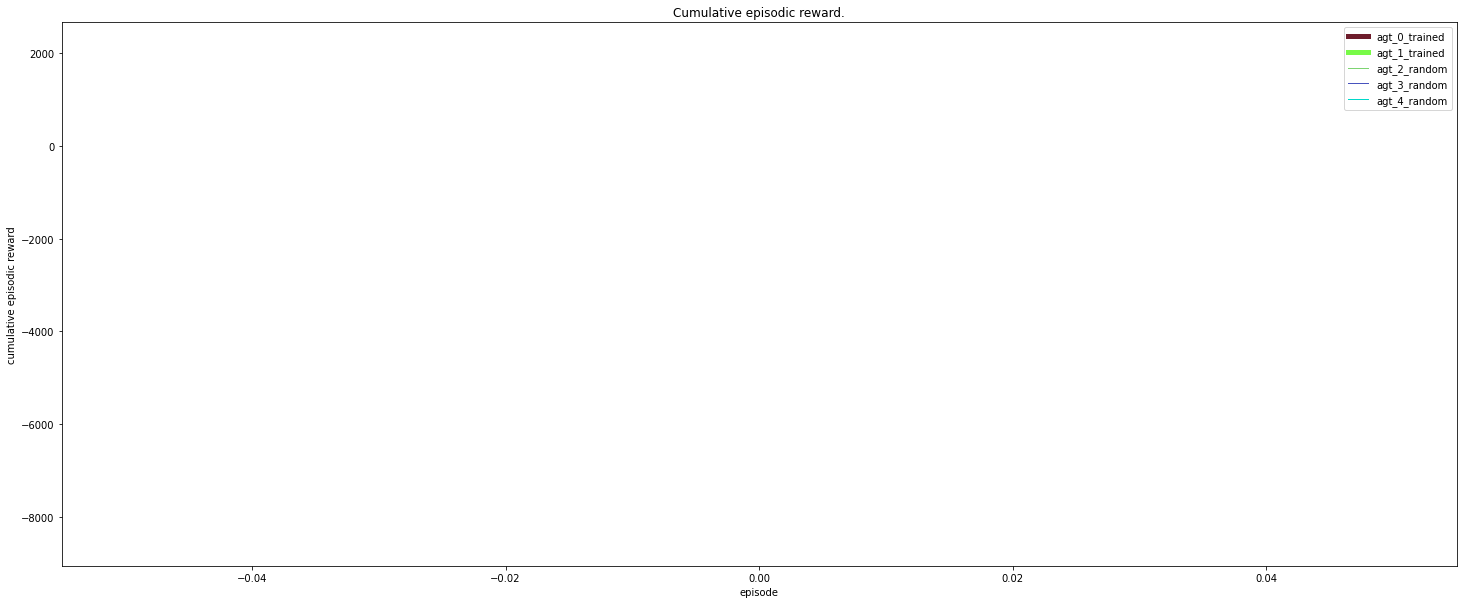

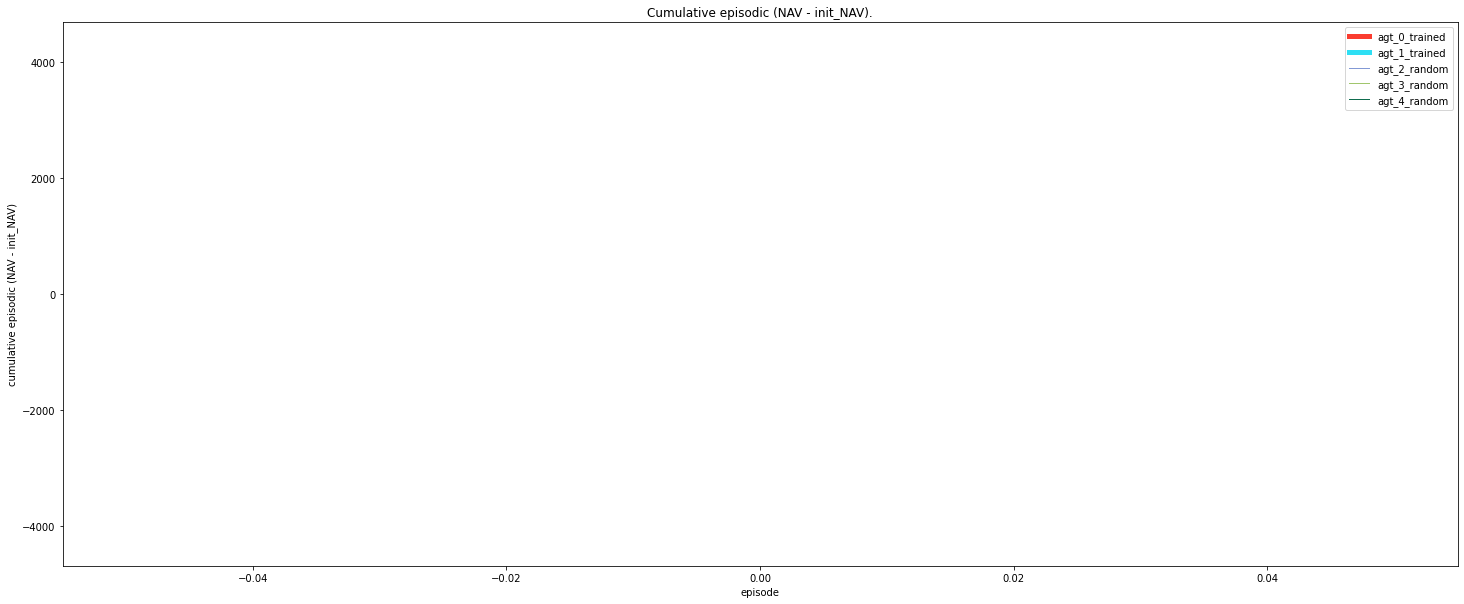

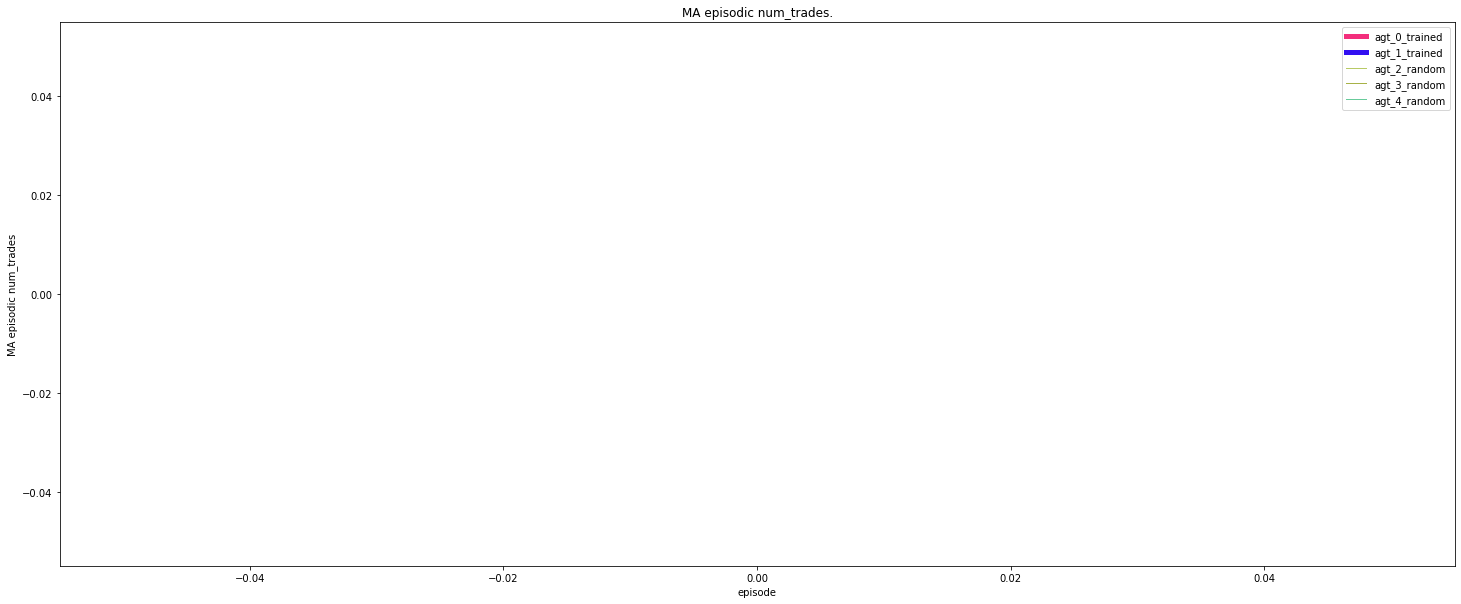

In [0]:
# Plot episodic results
plot_eps(init_cash, num_agents, num_trained_agent, "reward", policy_reward_store, 'agt_', '_policy_reward_list', '_trained', 'episode','cumulative episodic reward', 'Cumulative episodic reward.')
#plot_eps(init_cash, num_agents, num_trained_agent, "reward", reward_store, 'agt_', '_reward_list', '_trained', 'episode','cumulative episodic raw reward', 'Last step raw reward, unlike policy_reward_store which is total reward/eps.') # last step raw reward, unlike policy_reward_store which is total reward/eps.
plot_eps(init_cash, num_agents, num_trained_agent, "NAV", NAV_store, 'agt_', '_NAV_list', '_trained', 'episode','cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV).')
plot_eps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_store, 'agt_', '_num_trades_list', '_trained', 'episode','MA episodic num_trades', 'MA episodic num_trades.')   

# Steps from last episode.

In [0]:

obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")


# load last episode for all agents
#load_json(write_last_eps_steps_dir, max_step, obs_store, act_store, infos_store)
load_json_gzip(write_last_eps_steps_dir, max_step, obs_store, act_store, infos_store)

0_0_748325392.gzip
1_1_748325392.gzip
2_2_748325392.gzip
3_3_748325392.gzip
4_4_748325392.gzip
5_0_1567954252.gzip
6_1_1567954252.gzip
7_2_1567954252.gzip
8_3_1567954252.gzip
9_4_1567954252.gzip
10_0_897168387.gzip
11_1_897168387.gzip
12_2_897168387.gzip
13_3_897168387.gzip
14_4_897168387.gzip
15_0_548577585.gzip
16_1_548577585.gzip
17_2_548577585.gzip
18_3_548577585.gzip
19_4_548577585.gzip
20_0_33617711.gzip
21_1_33617711.gzip
22_2_33617711.gzip
23_3_33617711.gzip
24_4_33617711.gzip
25_0_1412784120.gzip
26_1_1412784120.gzip
27_2_1412784120.gzip
28_3_1412784120.gzip
29_4_1412784120.gzip
30_0_923444706.gzip
31_1_923444706.gzip
32_2_923444706.gzip
33_3_923444706.gzip
34_4_923444706.gzip
35_0_206710062.gzip
36_1_206710062.gzip
37_2_206710062.gzip
38_3_206710062.gzip
39_4_206710062.gzip
40_0_488659976.gzip
41_1_488659976.gzip
42_2_488659976.gzip
43_3_488659976.gzip
44_4_488659976.gzip
45_0_1271420079.gzip
46_1_1271420079.gzip
47_2_1271420079.gzip
48_3_1271420079.gzip
49_4_1271420079.gzip


In [0]:
reward_dict = get_last_eps_steps(num_agents, 'reward', infos_store, 'agt_', '_infos_list')
NAV_dict = get_last_eps_steps(num_agents, 'NAV', infos_store, 'agt_', '_infos_list')
num_trades_dict = get_last_eps_steps(num_agents, 'num_trades', infos_store, 'agt_', '_infos_list')

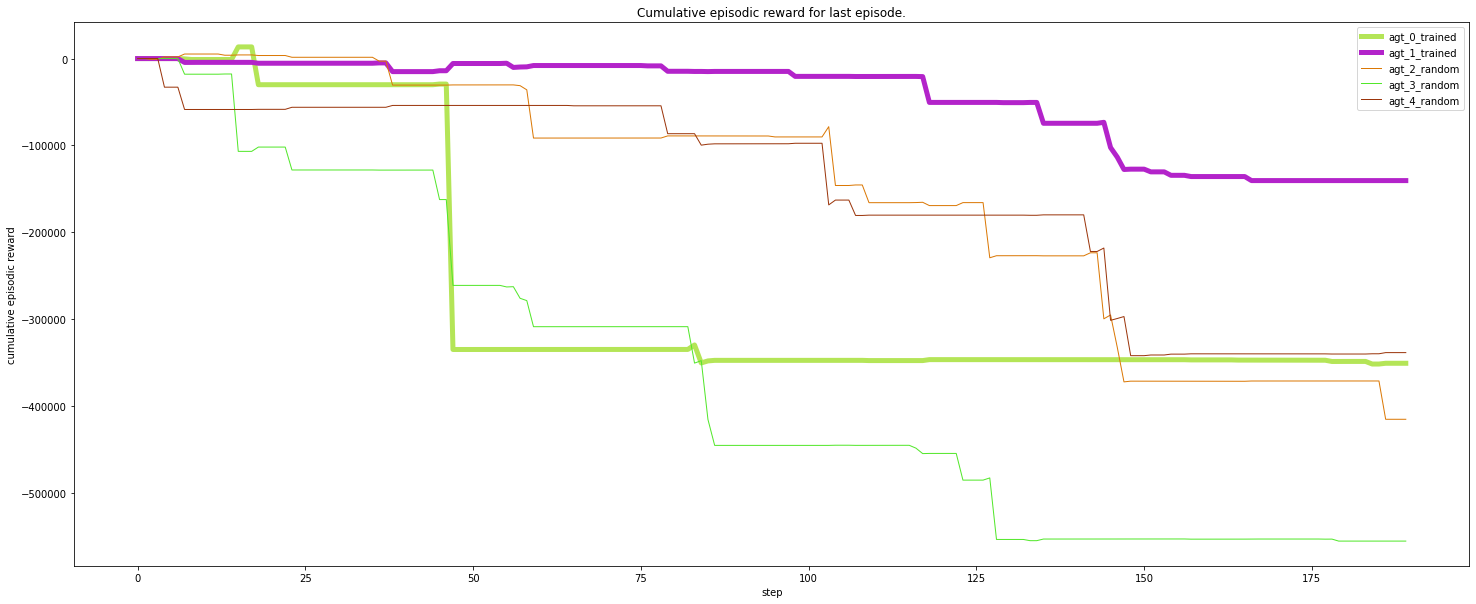

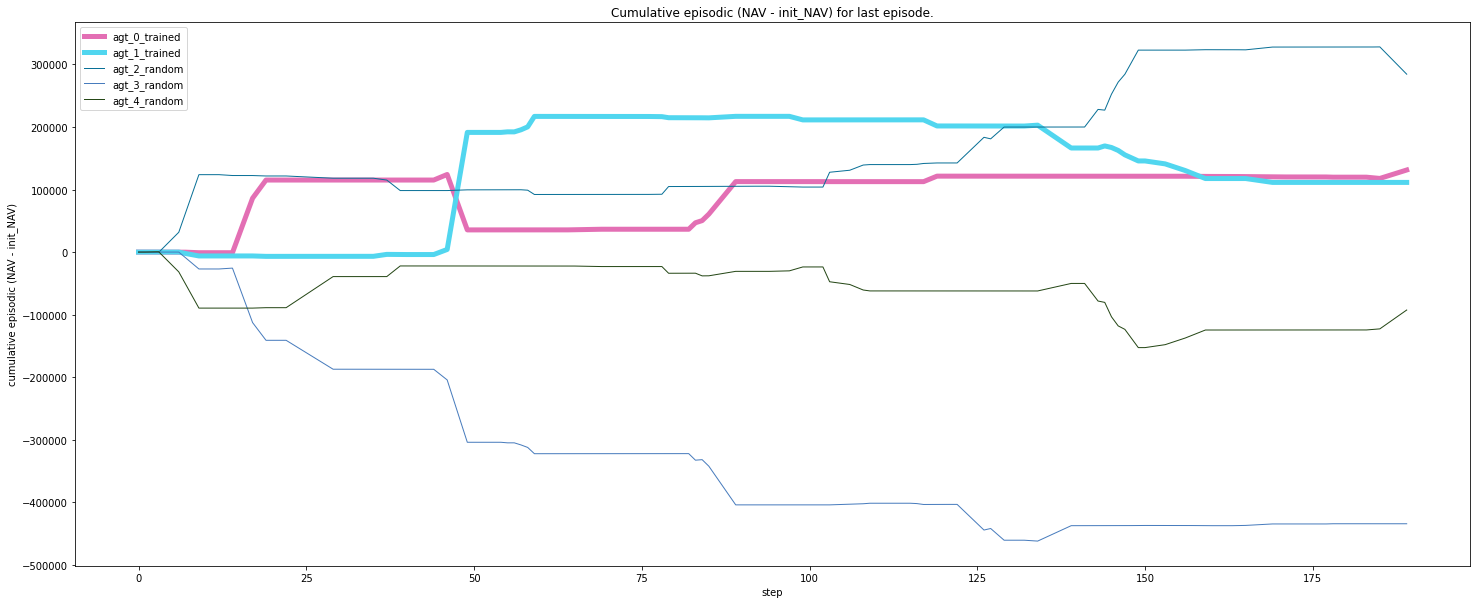

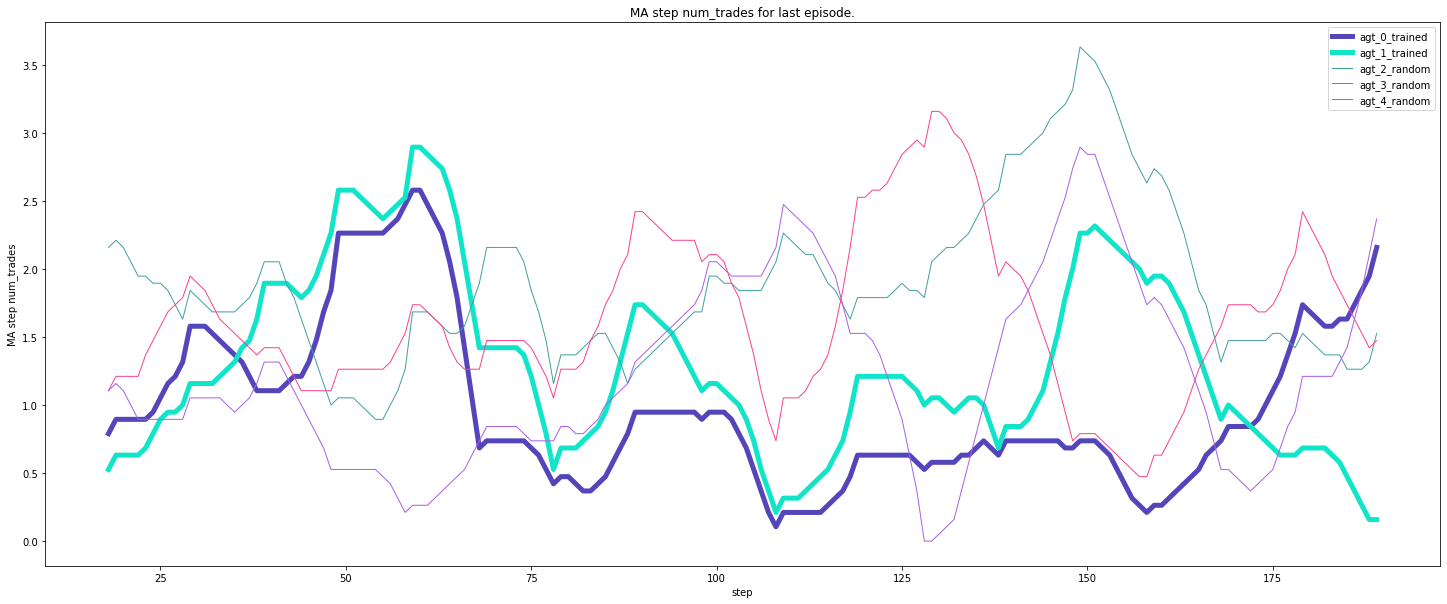

In [0]:
plot_last_eps_steps(reward_dict, num_trained_agent, 'reward', init_cash, "agt_", "reward_dict", "_trained", 'cumulative episodic reward', 'Cumulative episodic reward for last episode.')    
plot_last_eps_steps(NAV_dict, num_trained_agent, 'NAV', init_cash, "agt_", "NAV_dict", "_trained", 'cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV) for last episode.')  
plot_last_eps_steps(num_trades_dict, num_trained_agent, 'num_trades', init_cash, "agt_", "num_trades_dict", "_trained", 'MA step num_trades', 'MA step num_trades for last episode.')      

#LOB

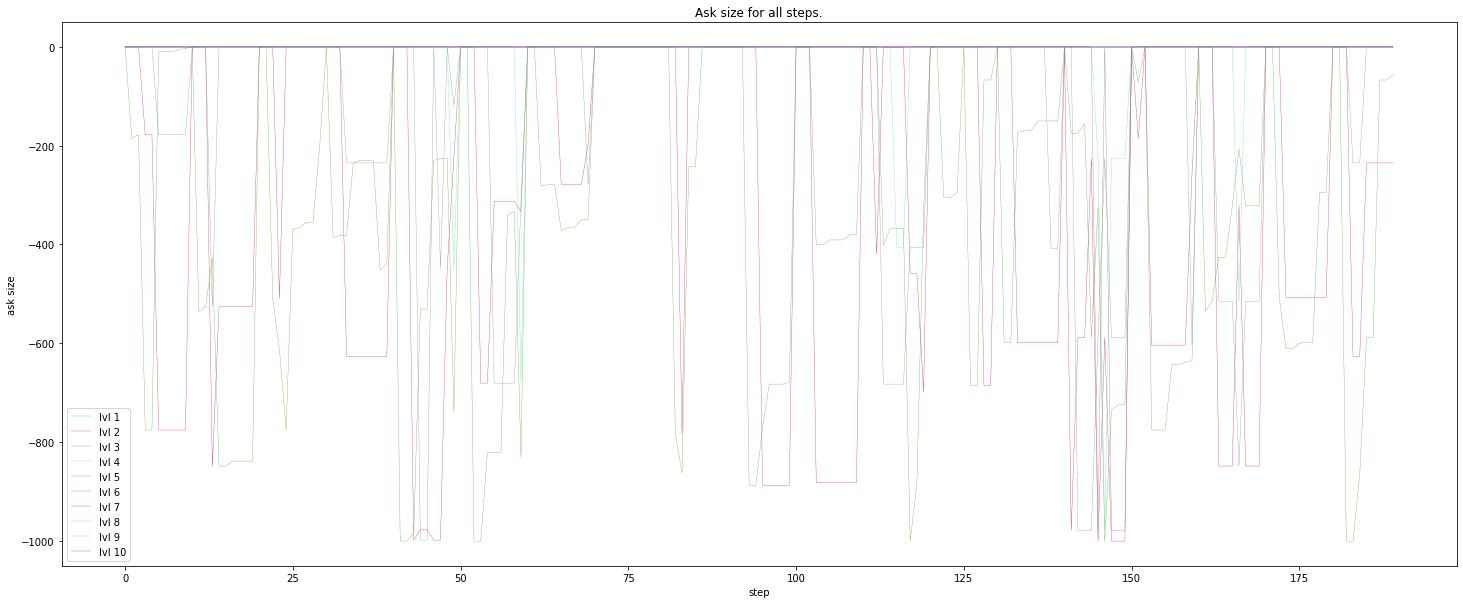

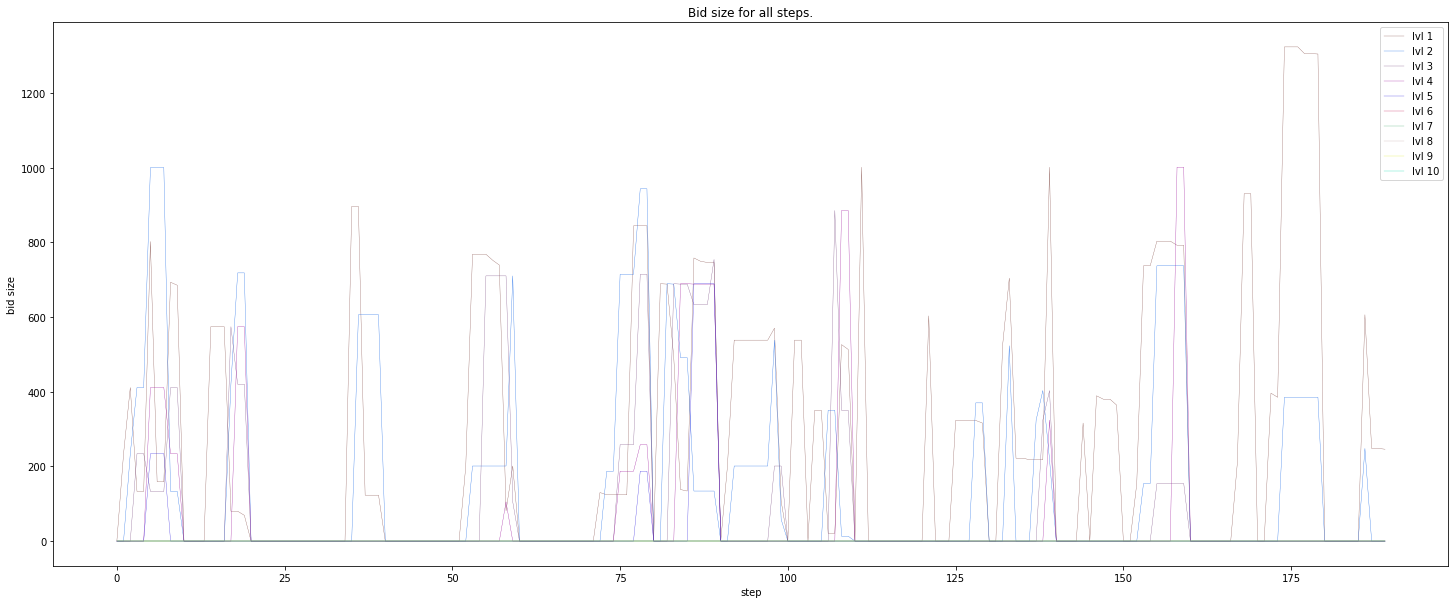

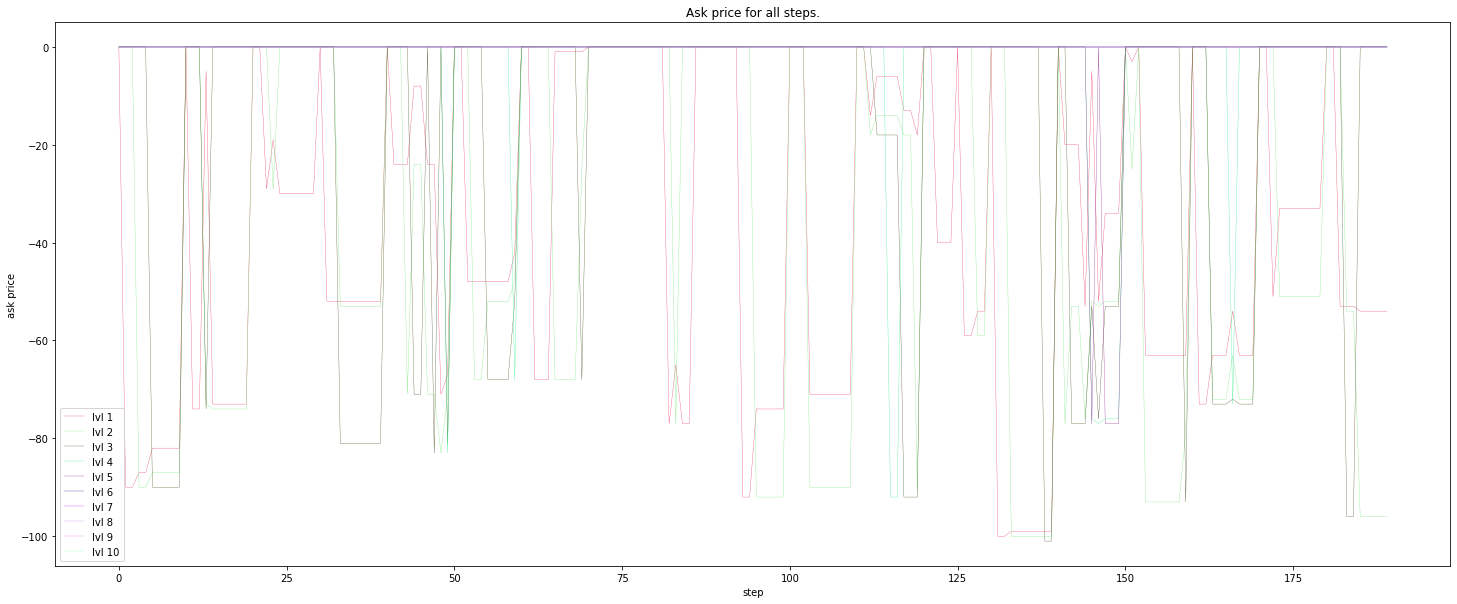

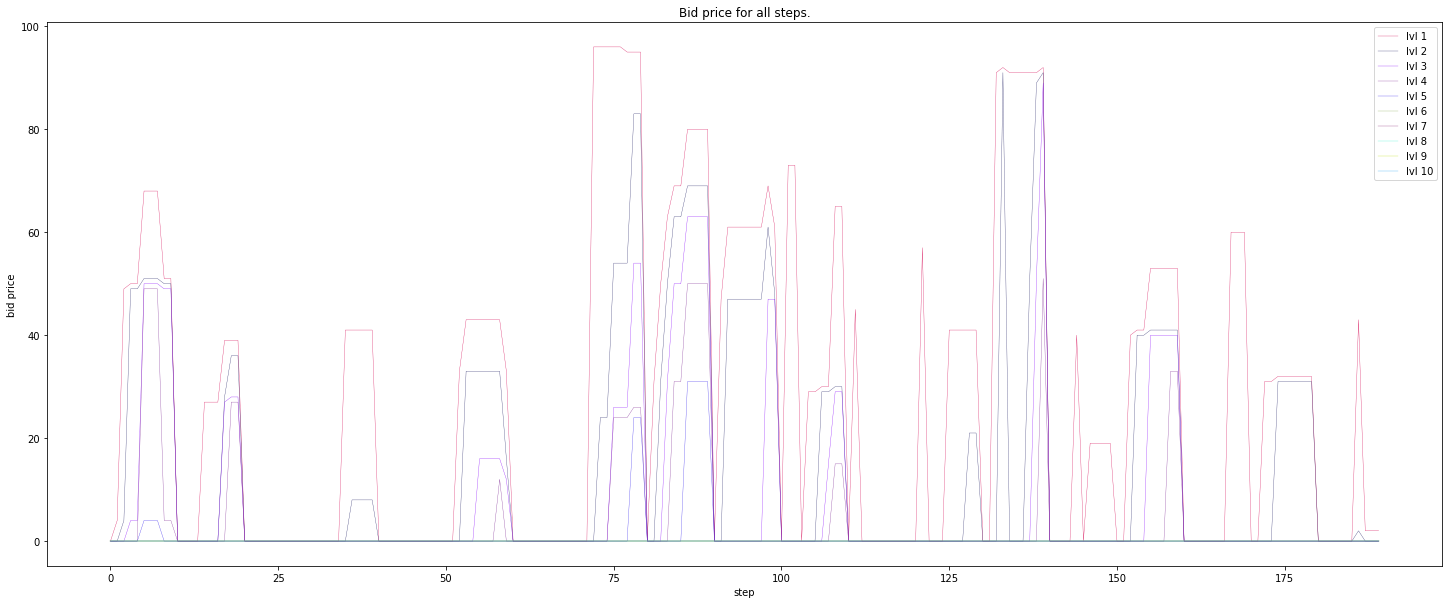

In [0]:
# Plot obs for all steps in last episode
show_obs(obs_store)

#Order Imbalance & midpoint price.

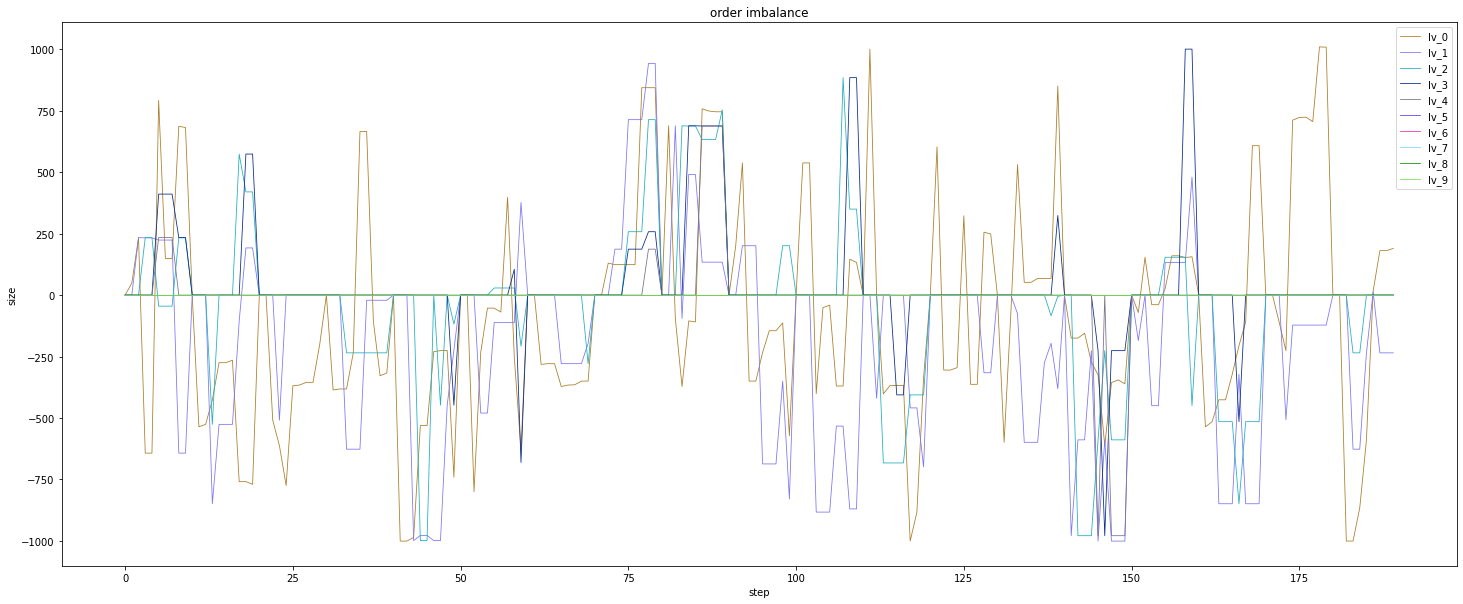

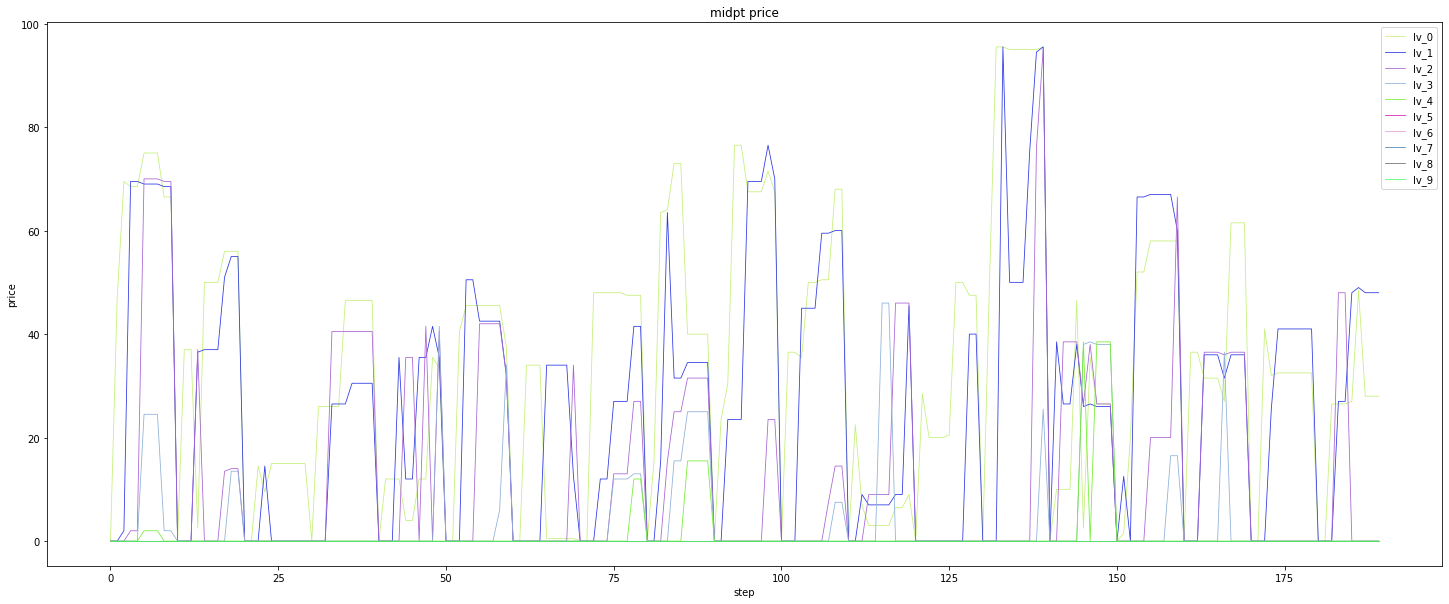

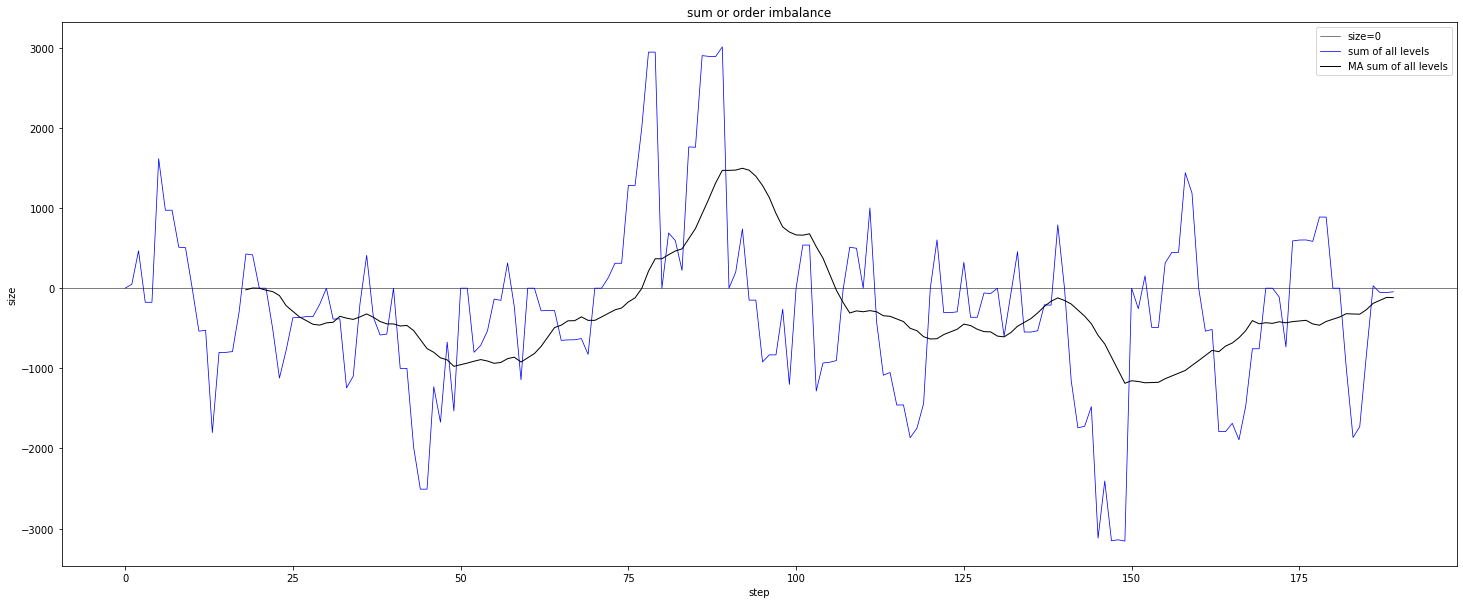

In [0]:
bid_size_start = 0
bid_price_start = 10
ask_size_start = 20
ask_price_start = 30
offset = 10    
key = "agt_0_obs_list"

bid_size_lv_dict = get_lv_dict(bid_size_start, bid_size_start + offset, obs_store, key)
ask_size_lv_dict = get_lv_dict(ask_size_start, ask_size_start + offset, obs_store, key)
bid_price_lv_dict = get_lv_dict(bid_price_start, bid_price_start + offset, obs_store, key)
ask_price_lv_dict = get_lv_dict(ask_price_start, ask_price_start + offset, obs_store, key)

size_imb_dict = size_imb(bid_size_lv_dict, ask_size_lv_dict)
midpt_price_dict = midpt_price(bid_price_lv_dict, ask_price_lv_dict)

plot_imb(size_imb_dict, "order imbalance", "size")
plot_imb(midpt_price_dict, "midpt price", "price")  

res = sum_all_lv(size_imb_dict)      
plot_sum_imb(res, "sum or order imbalance", "size")

#LOB subplots.

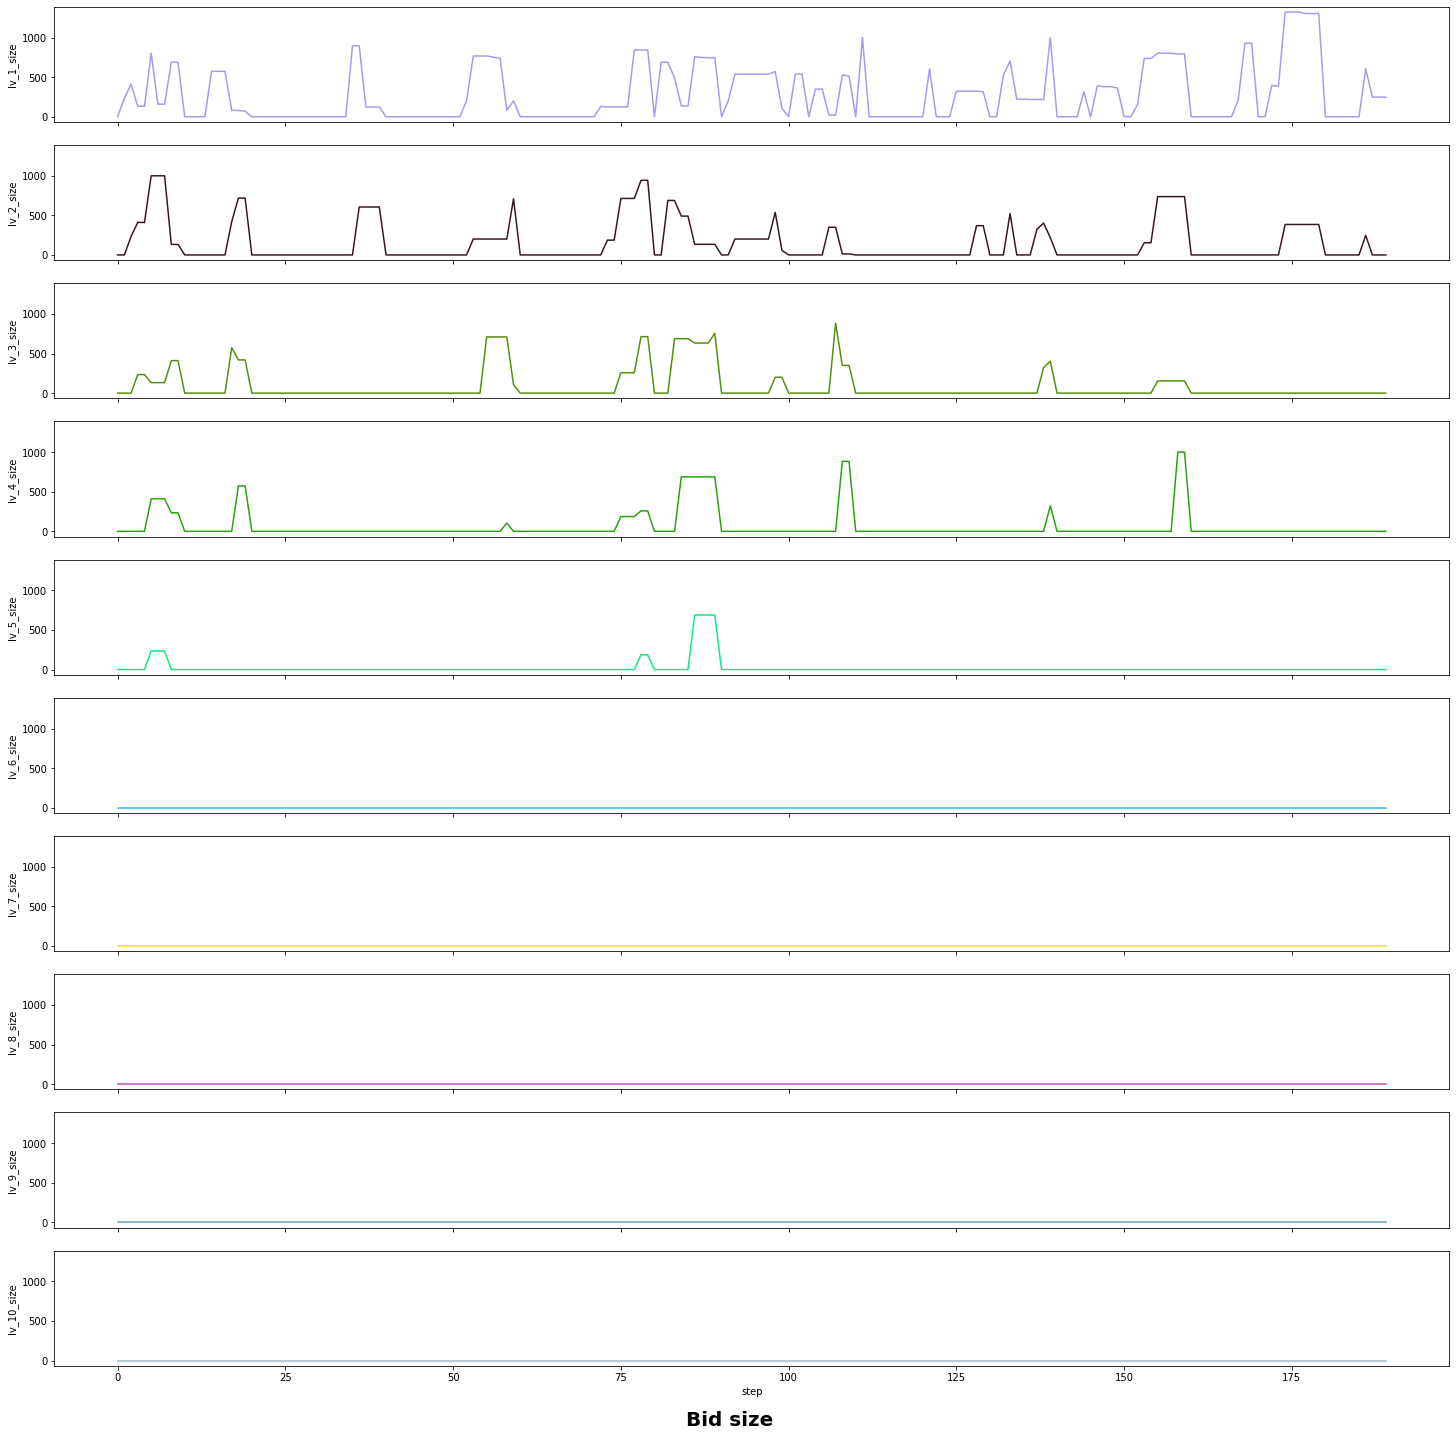

In [0]:
subplot_lv(bid_size_lv_dict, bid_size_start, (25,25), 'Bid size', '_size')

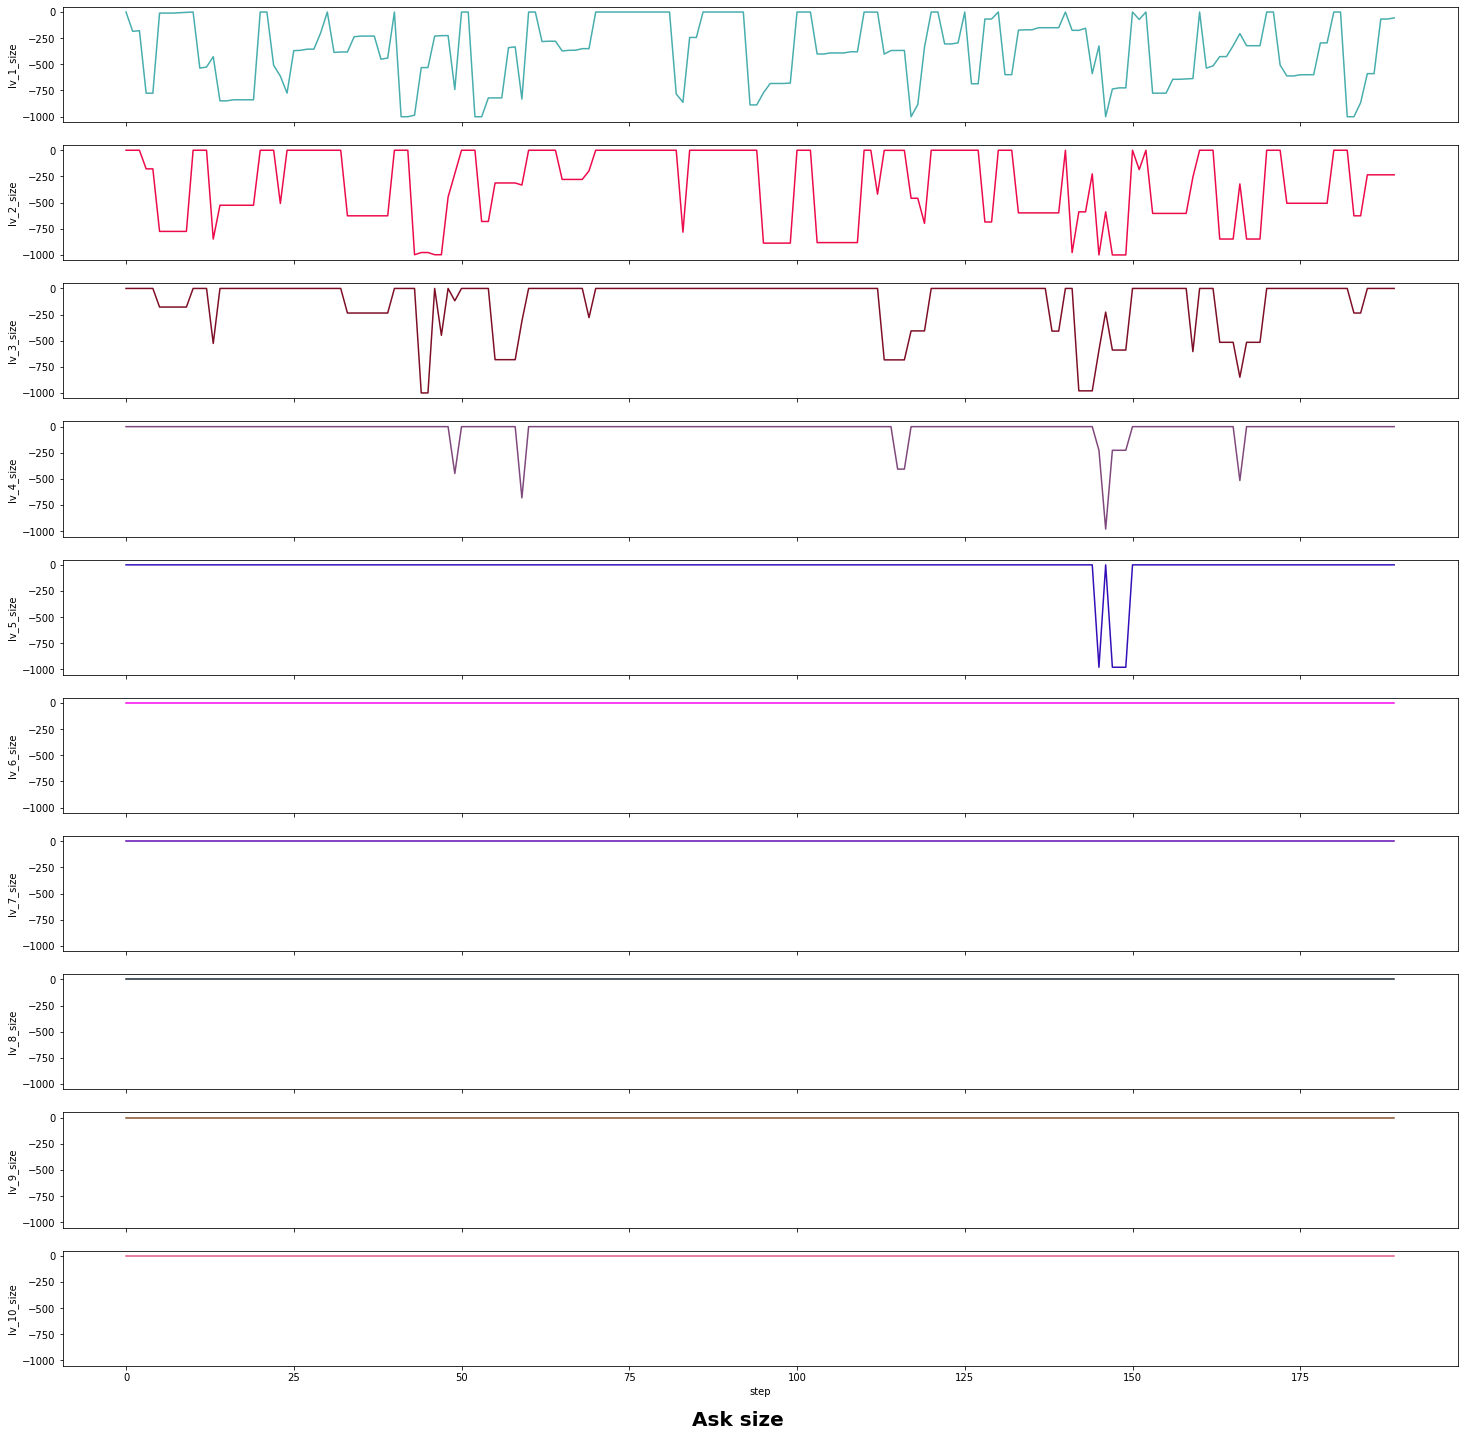

In [0]:
subplot_lv(ask_size_lv_dict, ask_size_start, (25,25), 'Ask size', '_size')

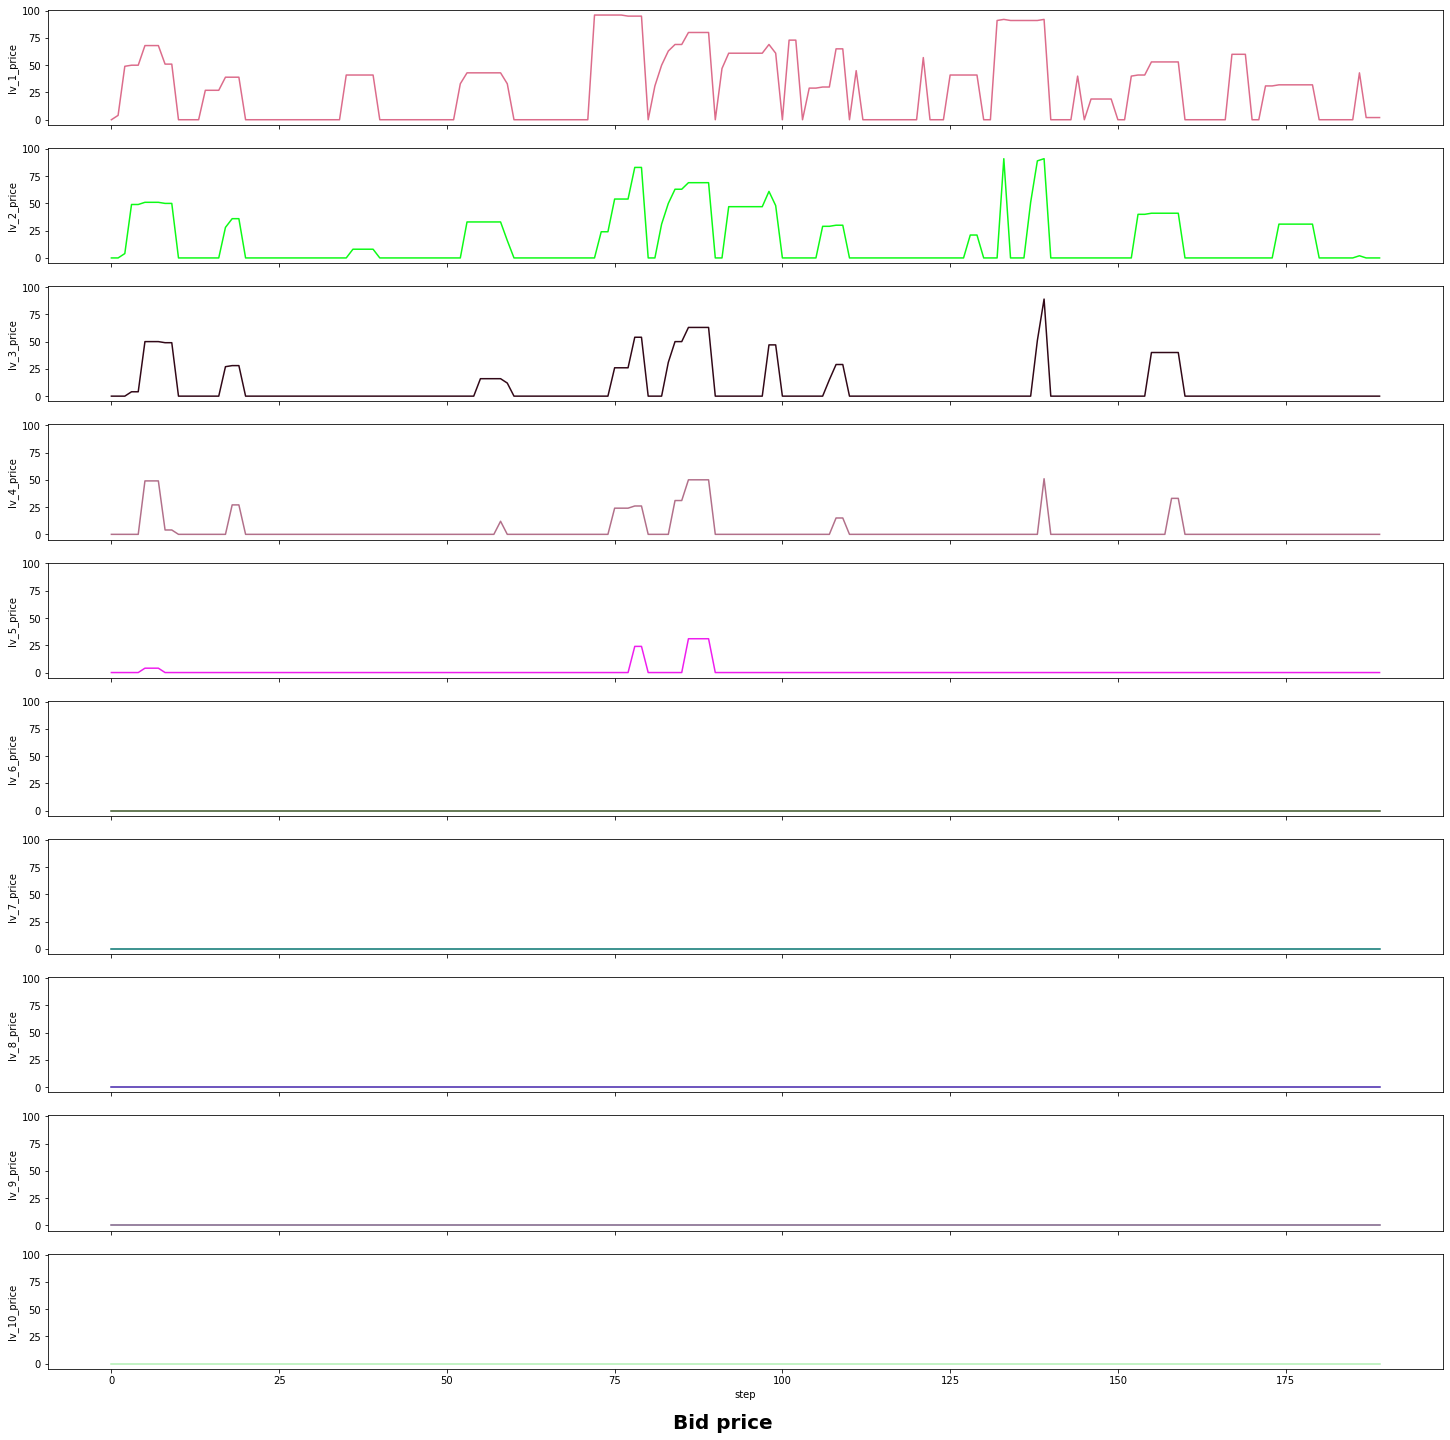

In [0]:
subplot_lv(bid_price_lv_dict, bid_price_start, (25,25), 'Bid price', '_price')

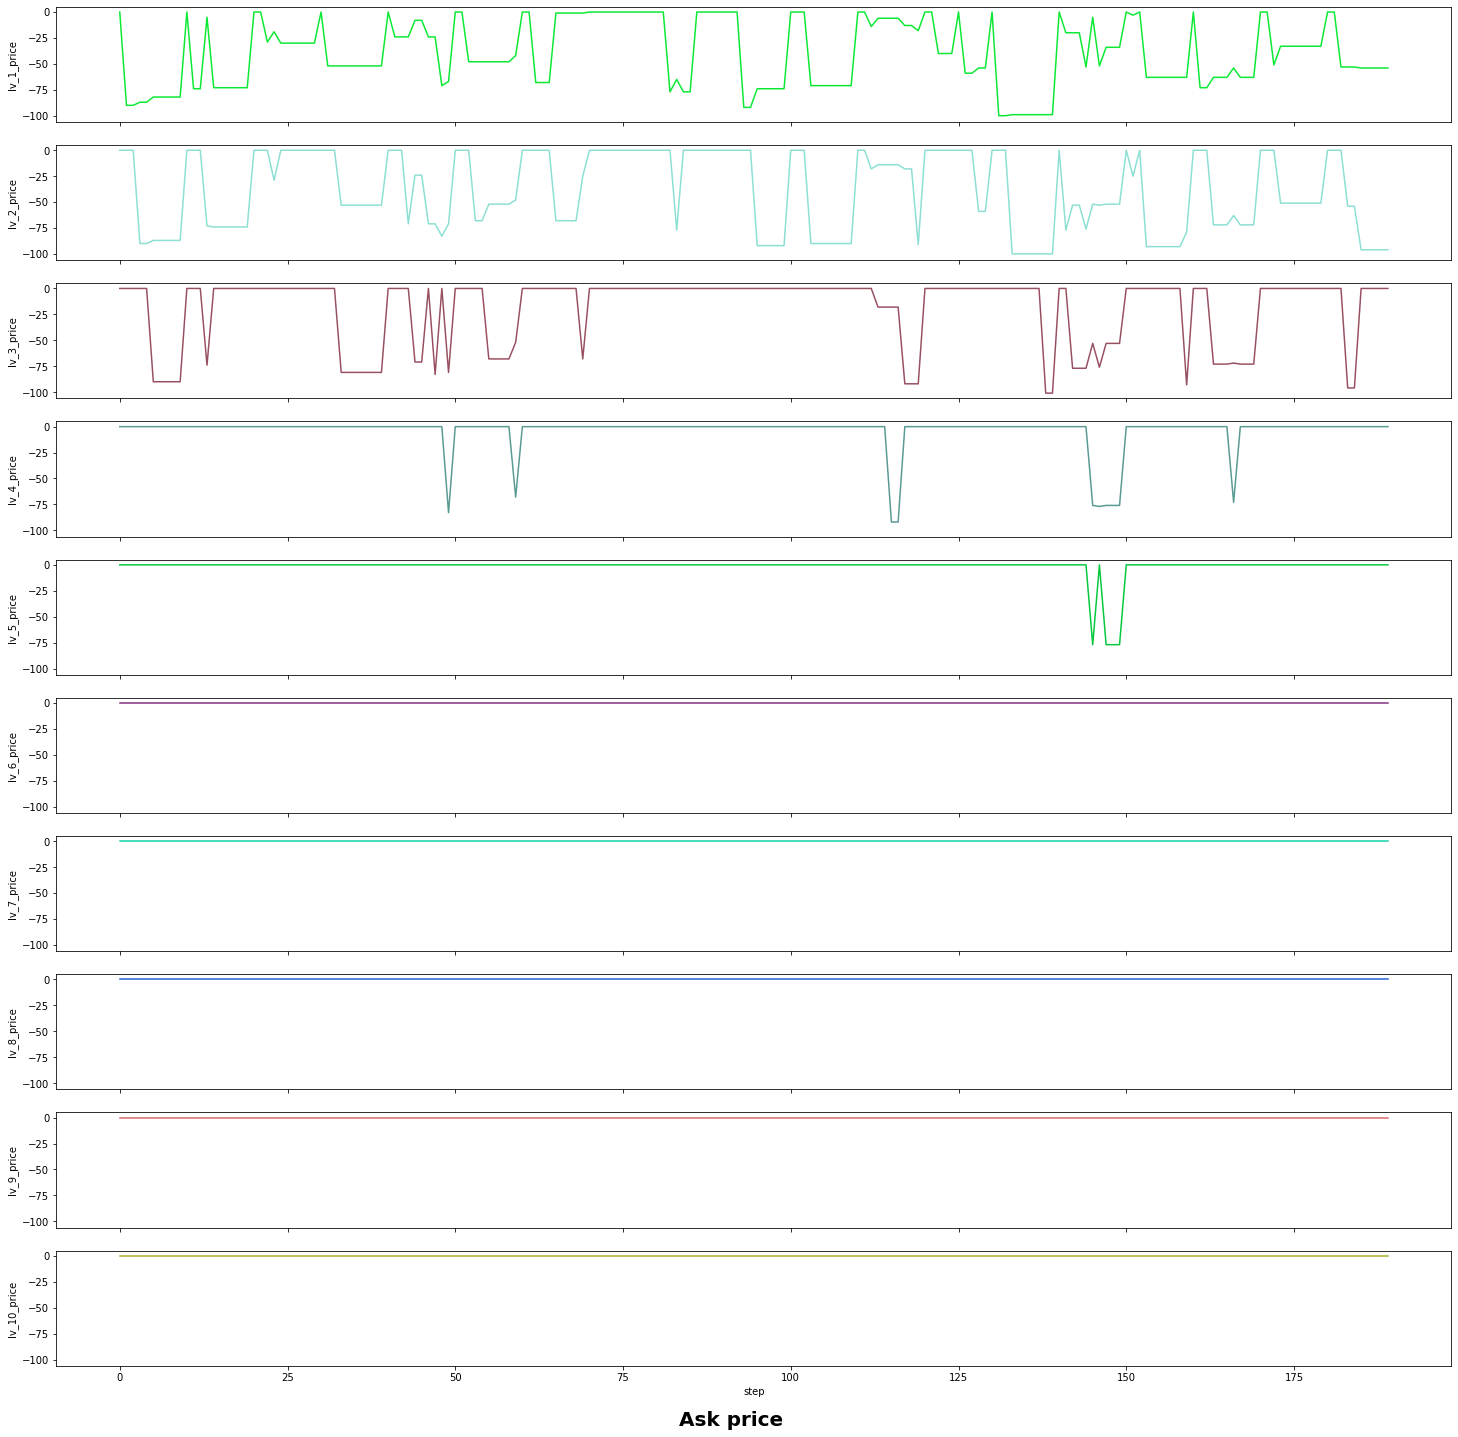

In [0]:
subplot_lv(ask_price_lv_dict, ask_price_start, (25,25), 'Ask price', '_price')

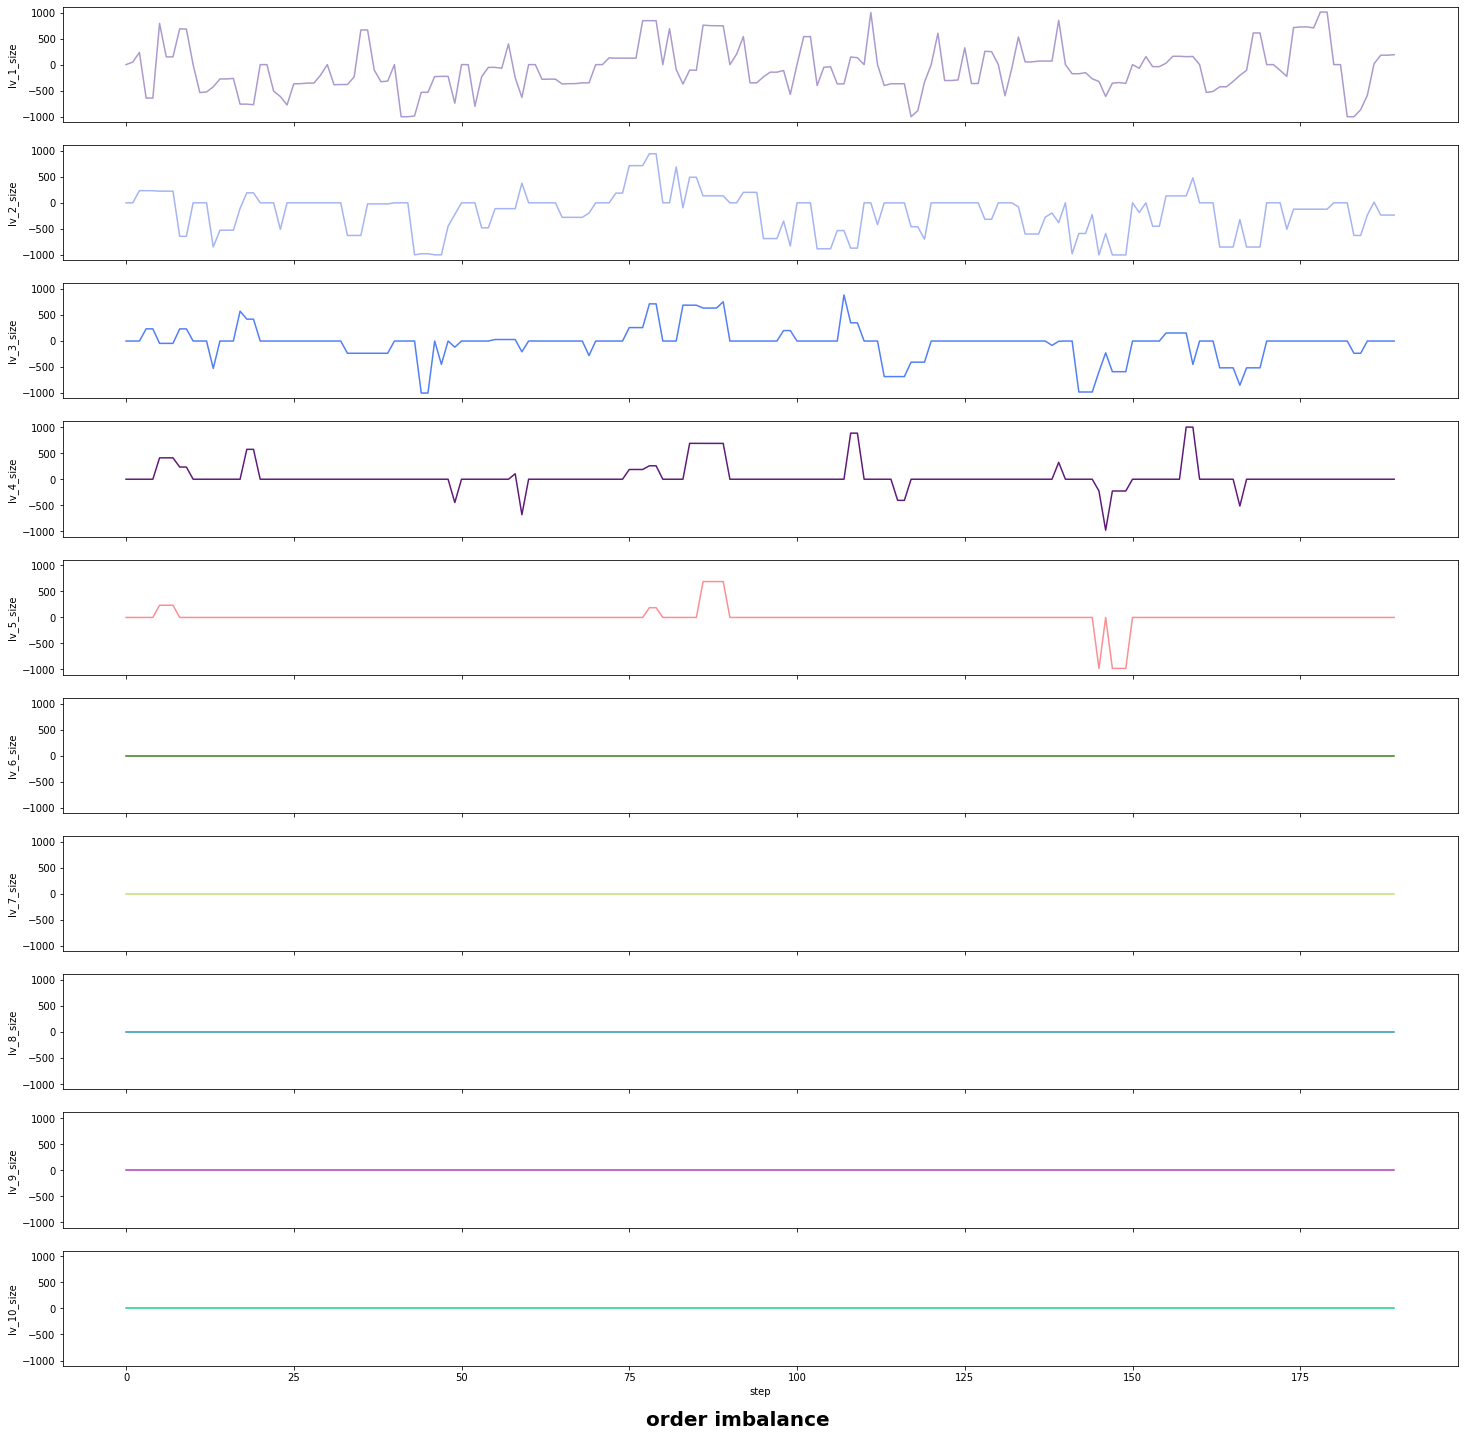

In [0]:
subplot_lv(size_imb_dict, 0, (25,25), 'order imbalance', '_size')

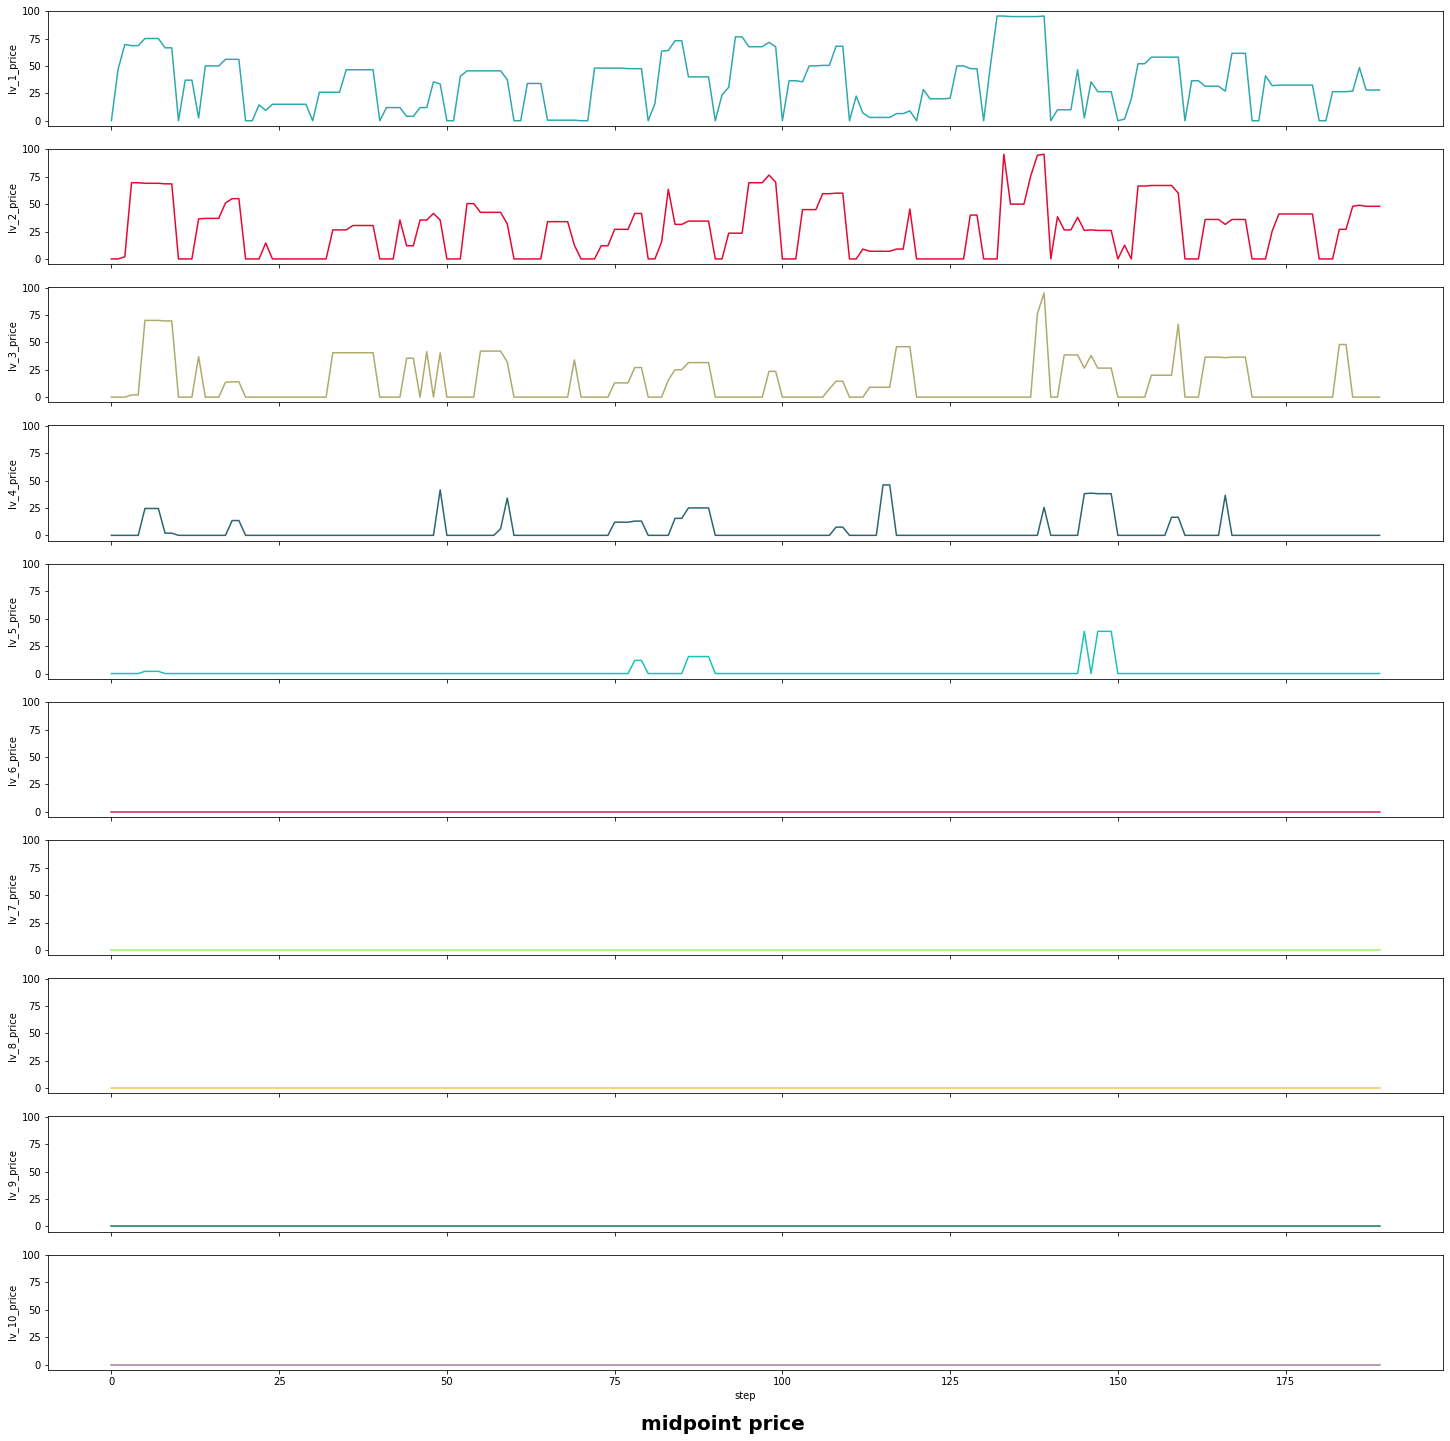

In [0]:
subplot_lv(midpt_price_dict, 0, (25,25), 'midpoint price', '_price')